In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [89]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=2, num_classes=10):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784 + num_classes, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_var = nn.Linear(256, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid() #for cross entropy in recon loss
            #nn.Tanh() # for MSE loss in recon loss or remove activation
        )
        
    def encode(self, x, c):
        x = x.view(-1, 784)
        c = F.one_hot(c, self.num_classes).float()
        x = torch.cat([x, c], dim=1)
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
        
    def decode(self, z, c):
        c = F.one_hot(c, self.num_classes).float()
        z = torch.cat([z, c], dim=1)
        x = self.decoder(z)
        return x.view(-1, 1, 28, 28)
    
    def forward(self, x, c):
        mu, log_var = self.encode(x, c)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, c), mu, log_var


        

def train(model, device, train_loader, optimizer, epoch, losses):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data, target)
        recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + kl_loss
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    avg_loss = epoch_loss / len(train_loader.dataset)
    losses.append(avg_loss)
    return losses


In [90]:
def train(model, device, train_loader, optimizer, epoch, losses_dict):
    model.train()
    epoch_recon_loss = 0
    epoch_kl_loss = 0
    epoch_total_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data, target)
        recon_loss = F.binary_cross_entropy(recon_batch, data, reduction='sum')
        #recon_loss = F.mse_loss(recon_batch, data, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        total_loss = recon_loss + kl_loss
        
        total_loss.backward()
        optimizer.step()
        
        epoch_recon_loss += recon_loss.item()
        epoch_kl_loss += kl_loss.item()
        epoch_total_loss += total_loss.item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {total_loss.item():.6f}')
    
    dataset_size = len(train_loader.dataset)
    losses_dict['recon'].append(epoch_recon_loss / dataset_size)
    losses_dict['kl'].append(epoch_kl_loss / dataset_size)
    losses_dict['total'].append(epoch_total_loss / dataset_size)
    
    return losses_dict

In [91]:
def plot_losses(losses_dict):
    plt.figure(figsize=(10, 5))
    plt.plot(losses_dict['recon'], label='Reconstruction Loss')
    plt.plot(losses_dict['kl'], label='KL Loss')
    plt.plot(losses_dict['total'], label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses Over Time')
    plt.legend()
    plt.show()


def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.show()

def sample_images(model, device, num_samples=10):
    model.eval()
    with torch.no_grad():
        # Sample latent vectors
        z = torch.randn(num_samples, model.latent_dim).to(device)
        # Generate one image per digit
        labels = torch.arange(10).to(device)
        samples = model.decode(z[:1].repeat(10, 1), labels)
        
        # Plot
        fig, axes = plt.subplots(1, 10, figsize=(20, 2))
        for i, ax in enumerate(axes):
            ax.imshow(samples[i].cpu().squeeze(), cmap='gray')
            ax.axis('off')
            ax.set_title(f'Digit {i}')
        plt.show()


In [92]:
def generate_digit(model, device, digit, num_samples=5):
    """Generate multiple samples of a specific digit"""
    model.eval()
    with torch.no_grad():
        # Sample different latent vectors
        # create random latent vectors of shape (num_sample, latent_dim)
        # each row is a different random point in latent space
        
        z = torch.randn(num_samples, model.latent_dim).to(device)
        # Repeat the requested digit: [digit, digit, ..., digit]
        # if digit=3 and num_sample=5, creates: [3, 3, 3, 3, 3]
        
        label = torch.tensor([digit] * num_samples).to(device)

        # generate sample by decoding
        # -different z vectors (different points in latent space)
        # -same label (conditioning on the same digit)
        # result: different variations of the same digit
        
        # Generate samples
        samples = model.decode(z, label)
        
        # Plot
        fig, axes = plt.subplots(1, num_samples, figsize=(2*num_samples, 2))
        for i, ax in enumerate(axes):
            ax.imshow(samples[i].cpu().squeeze(), cmap='gray')
            ax.axis('off')
            ax.set_title(f'Sample {i+1}')
        plt.suptitle(f'Generated Digit: {digit}')
        plt.show()


In [93]:
def sample_all_digits(model, device):
    """Generate one sample for each digit"""
    model.eval()
    with torch.no_grad():
        # Use same latent vector for all digits to see conditional effect
        z = torch.randn(1, model.latent_dim).to(device)
        z = z.repeat(10, 1)  # Repeat for each digit
        # Generate one image per digit
        labels = torch.arange(10).to(device)
        samples = model.decode(z, labels)
        
        # Plot
        fig, axes = plt.subplots(1, 10, figsize=(20, 2))
        for i, ax in enumerate(axes):
            ax.imshow(samples[i].cpu().squeeze(), cmap='gray')
            ax.axis('off')
            ax.set_title(f'Digit {i}')
        plt.show()

In [94]:
def visualize_latent_space(model, device, test_loader):
    model.eval()
    z_list = []
    label_list = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            mu, _ = model.encode(data, target)
            z_list.append(mu.cpu().numpy())
            label_list.append(target.cpu().numpy())

    z = np.concatenate(z_list, axis=0)
    labels = np.concatenate(label_list, axis=0)

    plt.figure(figsize=(10,10))
    scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
    plt.colorbar(scatter)
    plt.title('latent space visualization')
    plt.xlabel('z[0]')
    plt.ylabel('z[1]')
    plt.show()
            

In [95]:
# training setup
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
batch_size = 64
epochs = 10
latent_dim = 10

In [96]:
# load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [97]:
# Initialize model and optimizer
model = ConditionalVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) # mse need lower lr
# Train model and track losses
losses_dict = {'recon': [], 'kl': [], 'total': []}
for epoch in range(1, epochs + 1):
    losses_dict = train(model, device, train_loader, optimizer, epoch, losses_dict)


Train Epoch: 1 [0/60000 (0%)]	Loss: 34890.488281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 12163.312500
Train Epoch: 1 [12800/60000 (21%)]	Loss: 10525.274414
Train Epoch: 1 [19200/60000 (32%)]	Loss: 8863.451172
Train Epoch: 1 [25600/60000 (43%)]	Loss: 8774.671875
Train Epoch: 1 [32000/60000 (53%)]	Loss: 8348.166016
Train Epoch: 1 [38400/60000 (64%)]	Loss: 8234.596680
Train Epoch: 1 [44800/60000 (75%)]	Loss: 7712.968262
Train Epoch: 1 [51200/60000 (85%)]	Loss: 7883.947266
Train Epoch: 1 [57600/60000 (96%)]	Loss: 7950.482422
Train Epoch: 2 [0/60000 (0%)]	Loss: 7739.692383
Train Epoch: 2 [6400/60000 (11%)]	Loss: 7372.008789
Train Epoch: 2 [12800/60000 (21%)]	Loss: 7433.506348
Train Epoch: 2 [19200/60000 (32%)]	Loss: 7384.858398
Train Epoch: 2 [25600/60000 (43%)]	Loss: 7489.550293
Train Epoch: 2 [32000/60000 (53%)]	Loss: 7351.652344
Train Epoch: 2 [38400/60000 (64%)]	Loss: 7241.787109
Train Epoch: 2 [44800/60000 (75%)]	Loss: 7621.986816
Train Epoch: 2 [51200/60000 (85%)]	Loss: 7258.847168
Tr

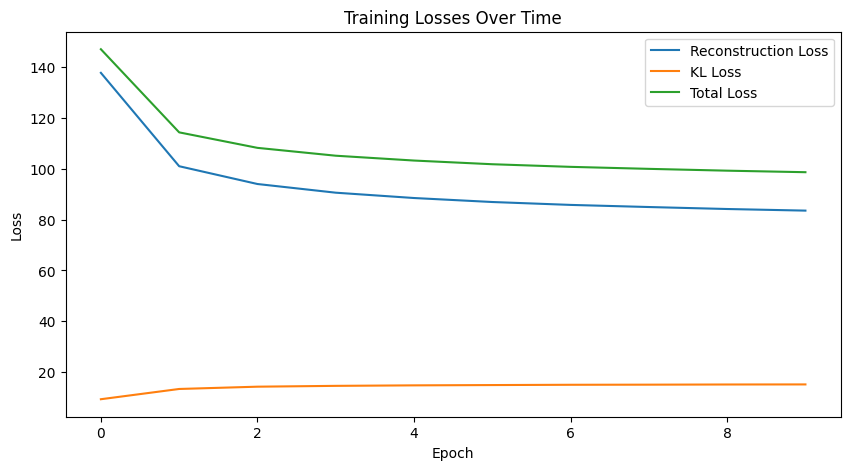

In [98]:
# Plot loss curves
plot_losses(losses_dict)


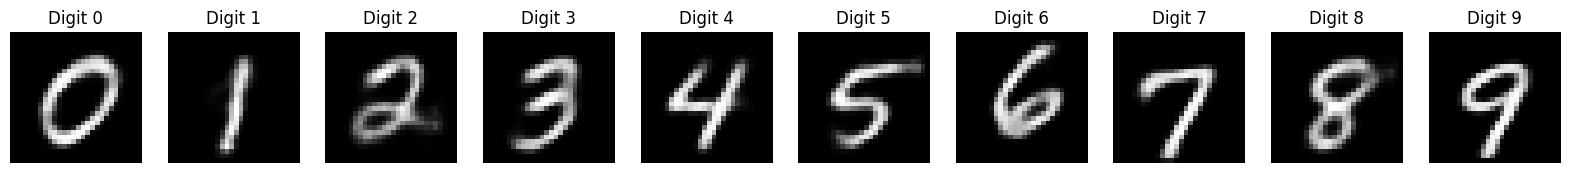

In [99]:
# Generate samples for all digits
sample_all_digits(model, device)

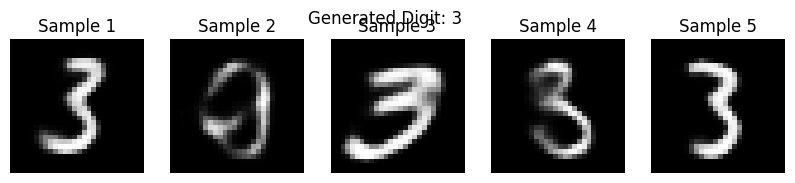

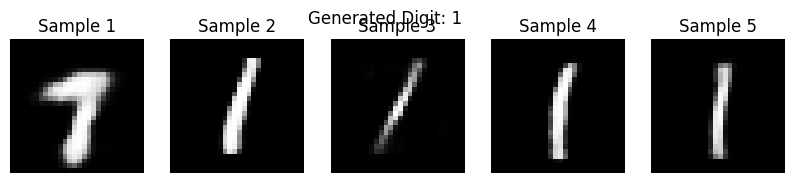

In [100]:
# Generate multiple samples of specific digits
generate_digit(model, device, digit=3)  # Generate digit 2
generate_digit(model, device, digit=1)  # Generate digit 7

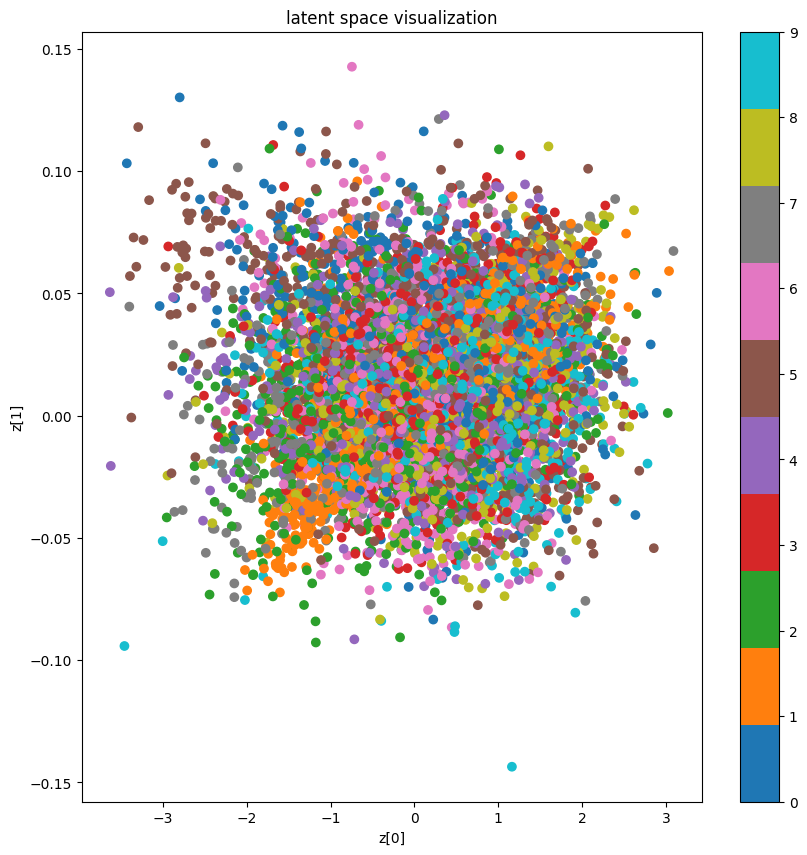

In [101]:
# Visualize latent space
visualize_latent_space(model, device, test_loader)

In [69]:
from sklearn.manifold import TSNE

def visualize_high_dim_latent(model, device, test_loader):
    model.eval()
    z_list, label_list = [], []
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            mu, _ = model.encode(data, target)
            z_list.append(mu.cpu().numpy())
            label_list.append(target.cpu().numpy())
    
    z = np.concatenate(z_list, axis=0)
    labels = np.concatenate(label_list, axis=0)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    z_tsne = tsne.fit_transform(z)
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(z_tsne[:, 0], z_tsne[:, 1], 
                         c=labels, cmap='tab10', 
                         alpha=0.6, s=10)
    plt.colorbar(scatter)
    plt.title('t-SNE Visualization of High-Dimensional Latent Space')
    plt.show()

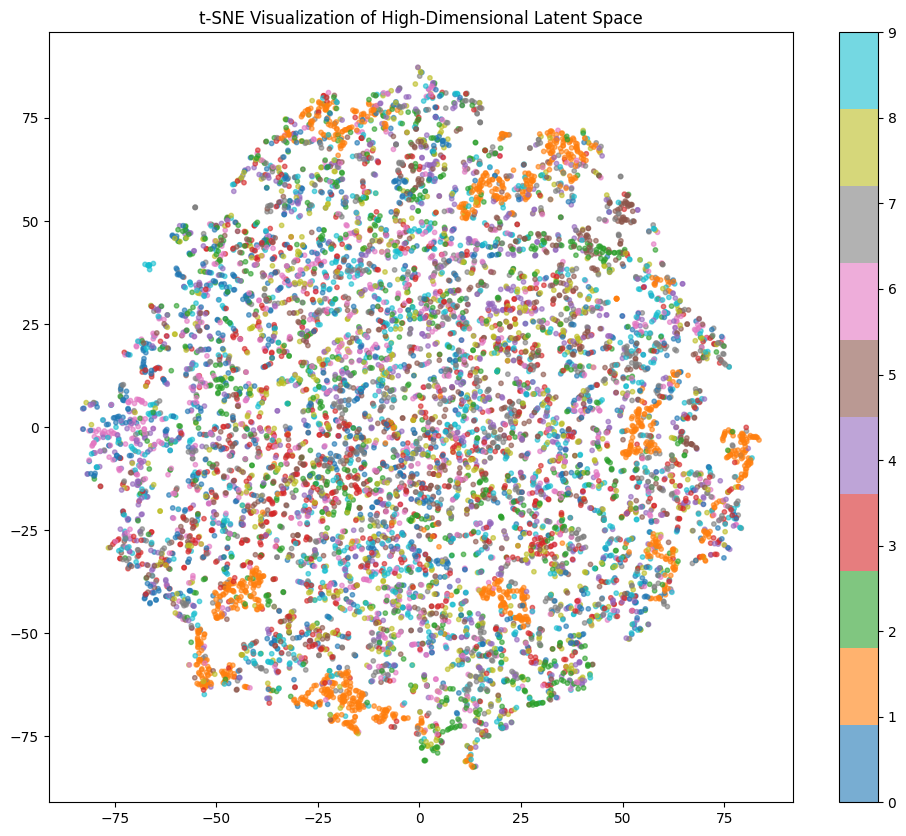

In [70]:
visualize_high_dim_latent(model, device, test_loader)